In [1]:
import numpy as np
import pandas as pd
import transformers
from PIL import Image
import os
import torch
from torch import nn

In [2]:
# main data
path_to_data = 'data/full'
individ_folders = sorted(os.listdir(path_to_data))

In [6]:
meta_training_full_labels = np.load('data/meta_training_full_labels.npy', allow_pickle=True).item()

In [ ]:
# Organise Samples
meta_testing_full_labels = np.load('data/meta_testing_full_labels.npy', allow_pickle=True).item()
full_list = os.listdir('data/full')

testing_list = [x[10:13] for x in meta_testing_full_labels['image']]
testing_list = sorted(list(set(testing_list)))

training_list = [y for y in full_list if y not in testing_list]
validation_list = testing_list[:-5]
testing_list = testing_list[:16]

In [8]:
# Organise Labels
import yaml
with open('yolo_full_set.yaml', 'r') as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

code_label = data['names']

In [9]:
for key, name in code_label.items():
    code_label[key] = name[:-4]
#code_label

In [10]:
def convert_code2label(code, code_label=None):
    return next((val for key, val in code_label.items() if key == code), None)

In [11]:
# load pretrained model
from ultralytics import YOLO
model = YOLO("runs/detect/train/weights/best.pt")

validation = model.val()
#val_box_map = validation.box.map

Ultralytics 8.3.34 🚀 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,611,961 parameters, 0 gradients, 6.5 GFLOPs


val: Scanning /home/katya/Huggingface/datasets/yolo_full/val/labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


                   all         15       1134      0.755      0.758       0.79       0.41
Calibration_Ball_Filled.npy         15         15          1          1      0.995      0.882
   Ilioisch_line_l.npy         15         15      0.962          1      0.995      0.752
   Ilioisch_line_r.npy         15         15      0.957          1      0.995      0.759
        LIST_A01_l.npy         15         15      0.404      0.363      0.464      0.175
        LIST_A01_r.npy         15         15      0.607      0.733      0.715      0.239
        LIST_A02_l.npy         15         15      0.846      0.733      0.815      0.368
        LIST_A02_r.npy         15         15      0.655      0.761      0.806      0.347
        LIST_F03_l.npy         15         15      0.856      0.933      0.939      0.405
        LIST_F03_r.npy         15         15      0.767      0.733      0.832      0.408
        LIST_F05_l.npy         15         15       0.96          1      0.995      0.433
        LIST_F05

In [12]:
# run predictions on the test sample
images = os.listdir('datasets/yolo_full/test/images')
all_results = {}
for image in images:
    result = model(f'datasets/yolo_full/test/images/{image}')
    name = image[:-4]
    all_results[name] = result[0]


image 1/1 /home/katya/Huggingface/datasets/yolo_full/test/images/083.jpg: 640x640 1 Calibration_Ball_Filled.npy, 1 Ilioisch_line_l.npy, 1 Ilioisch_line_r.npy, 1 LIST_A01_l.npy, 1 LIST_A01_r.npy, 1 LIST_A02_l.npy, 1 LIST_A02_r.npy, 1 LIST_F03_l.npy, 1 LIST_F03_r.npy, 1 LIST_F05_l.npy, 1 LIST_F05_r.npy, 1 LIST_F11_l.npy, 1 LIST_F11_r.npy, 1 LIST_F23_l.npy, 1 LIST_F23_r.npy, 1 LIST_F24_l.npy, 2 LIST_F24_r.npys, 1 LIST_F25_l.npy, 3 LIST_F25_r.npys, 2 LIST_F27_l.npys, 1 LIST_F27_r.npy, 3 LIST_F28_l.npys, 2 LIST_F28_r.npys, 1 LIST_F29_l.npy, 2 LIST_F29_r.npys, 1 LIST_F30_l.npy, 1 LIST_F33_r.npy, 1 LIST_FemHead_med_l.npy, 1 LIST_FemHead_med_r.npy, 2 LIST_FemHead_super_l.npys, 1 LIST_FemHead_super_r.npy, 1 LIST_P01_l.npy, 1 LIST_P01_r.npy, 1 Linea_iliopectinea_l.npy, 1 Linea_iliopectinea_r.npy, 1 Linea_terminalis.npy, 2 PELVIS_AIIS_l.npys, 2 PELVIS_AIIS_r.npys, 1 PELVIS_ASIS_l.npy, 1 PELVIS_Ilioacetabular_r.npy, 1 PELVIS_Iliopectineal_l.npy, 1 PELVIS_Iliopectineal_r.npy, 1 PELVIS_Iliosacral_j

In [13]:
import pandas as pd
def collect_class_accuracy(individ_summary, code_label):
    df = pd.DataFrame(individ_summary)
    df = df.set_index('name')
    classes = [int(x) for x in df['class'].to_list()]
    res = {}
    for c in range(len(code_label)):
        if c in classes:
            res[c] = df.loc[df['class']==c, 'confidence'].to_numpy()[0]
        else: res[c] = 0
    return res



In [14]:
stats = []
for key, result in all_results.items():
    summary = result.summary()
    class_accuracies = collect_class_accuracy(summary, code_label)
    class_accuracies['mean'] = (sum([float(x) for x in list(class_accuracies.values())]))/len(class_accuracies.keys())
    class_accuracies['name'] = key   
    stats.append(class_accuracies)
df = pd.DataFrame(stats)
df = df.set_index('name')

average_summary = {}
for col in range(len(code_label)):
    average_summary[convert_code2label(col,code_label=code_label)] = df[col].mean()
sorted_average_summary = dict(sorted(average_summary.items(), key=lambda item: item[1]))
# for lm, val in sorted_average_summary.items():
#     print(lm, val)

In [15]:
# filter out boxes with more than one versions
def assemble_count(yolo_prediction):
    boxes = yolo_prediction.boxes
    boxes_dict = {}
    for i, box in enumerate(boxes.xyxy):
        class_number = int((boxes.cls[i].cpu()).item())
        if class_number in boxes_dict.keys():
            continue # ignore boxes with less than the highest probability
        else: boxes_dict[class_number] = [(box.cpu()).tolist()]
    count_dict= dict(sorted(boxes_dict.items(), key=lambda item: item[0]))
    return count_dict

def remove_doubles(yolo_prediction):
    count_dict = assemble_count(yolo_prediction)
    boxes_dict = {}
    for key, val in count_dict.items():
        if len(val) == 1:
            label = convert_code2label(key, code_label=code_label)
            boxes_dict[label] = val
        else: continue
    return boxes_dict

In [16]:
dict_boxes_for_all = {}
for key, result in all_results.items():
    boxes_dict = remove_doubles(result)
    dict_boxes_for_all[key] = boxes_dict

In [18]:
# Initialize the processor
from transformers import SamModel, SamProcessor
processor = SamProcessor.from_pretrained("MedSAM", local_files_only = True)

# Load the model
model_loaded = SamModel.from_pretrained('pre_trained_full2401')
processor = SamProcessor.from_pretrained("MedSAM", local_files_only=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [19]:
# transform image
def transform_image(im_path):
    img_array = np.load(im_path)
    origImage =  img_array[img_array.files[0]]
    origImage = origImage*255/max(origImage.flatten())
    image = Image.fromarray(np.uint8(origImage)).convert('RGB')
    return image

# obtain predictions
def obtain_predictions(loaded_dict_of_boxes, path_to_images):
    results = {}
    to_process = list(loaded_dict_of_boxes.keys())
    # for each image:
    for i, name in enumerate(to_process):
        full_path = os.path.join(path_to_images, name, 'image', name+'.npz')

        if len(results.keys()) == 0 or name not in list(results.keys()):
            print('new ind', name)
            results[name] = {}      
            image = transform_image(full_path)

        # for each box:
        ind_boxes_dict = loaded_dict_of_boxes[name]   
        for label, prompt in ind_boxes_dict.items():
            # prepare image + box prompt for the model
            inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model_loaded(**inputs, multimask_output=False)
                
            # upsample output
            predicted_masks = nn.functional.interpolate(outputs.pred_masks.squeeze(1),
                    size=(1024, 1024),
                    mode='bilinear',
                    align_corners=False)
            
            # transfer to cpu:
            medsam_seg_prob = predicted_masks.cpu().numpy().squeeze()
            medsam_seg_prob = (medsam_seg_prob > 0.1).astype(np.float16)
            print(np.sum(medsam_seg_prob))

            # add to the individual dictionary
            results[name][label] = medsam_seg_prob

    return    results

In [20]:
path_to_images = 'data/full'
testing_results = obtain_predictions(dict_boxes_for_all, path_to_images)

new ind 083
5400.0
2452.0
2440.0
185.0
161.0
152.0
138.0
133.0
139.0
137.0
131.0
162.0
173.0
140.0
169.0
163.0
136.0
120.0
147.0
158.0
132.0
171.0
132.0
145.0
130.0
149.0
144.0
149.0
158.0
155.0
149.0
160.0
139.0
2566.0
2406.0
8696.0
140.0
147.0
148.0
130.0
157.0
155.0
144.0
153.0
152.0
148.0
149.0
133.0
131.0
146.0
171.0
137.0
128.0
128.0
155.0
121.0
136.0
137.0
142.0
1148.0
958.0
2904.0
2832.0
11810.0
10750.0
18100.0
17980.0
2584.0
3968.0
new ind 001
5804.0
2214.0
2282.0
148.0
136.0
142.0
140.0
145.0
137.0
164.0
154.0
156.0
161.0
157.0
147.0
143.0
142.0
148.0
149.0
168.0
118.0
139.0
152.0
146.0
132.0
133.0
130.0
156.0
145.0
144.0
137.0
143.0
144.0
149.0
136.0
136.0
143.0
164.0
148.0
141.0
153.0
136.0
137.0
142.0
144.0
732.0
807.0
2400.0
2328.0
12250.0
13260.0
13320.0
13120.0
3110.0
2560.0
new ind 062
5280.0
2388.0
1594.0
167.0
166.0
190.0
137.0
141.0
184.0
139.0
159.0
162.0
174.0
141.0
184.0
153.0
166.0
191.0
166.0
155.0
177.0
161.0
166.0
141.0
130.0
158.0
172.0
162.0
155.0
161.0
160

In [21]:
np.save('data/testing_predictions_full_yolo_boxes.npy', testing_results)

In [22]:
# Load the data
results = np.load('data/testing_predictions_full_yolo_boxes.npy', allow_pickle=True).item()

In [23]:
names, items = zip(*results.items())

In [24]:
# Paths and labels
dicom_images_path = 'data/root_image_folder'
path_to_data = 'data/full'
all_labels = sorted(os.listdir(os.path.join(path_to_data, '001', 'labels')))

lms_have = ['PELVIS', 'LIST']
patches_have = ['femur_cort_med_', 'femur_cort_lat_', 'Ball_Filled']
outl_have = ['Pfannendach', 'Shenton', 'ilium', 'Linea', 'Ilioisch']

lms = {label for label in all_labels if any(substring in label for substring in lms_have)}
patches = {label for label in all_labels if any(substring in label for substring in patches_have)}
outl = {label for label in all_labels if any(substring in label for substring in outl_have)}


In [25]:
def dice_coe(mask1, mask2):
    """Calculate Dice coefficient between two masks."""
    intersect = np.sum(mask1 * mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    return (2 * intersect) / (fsum + ssum) if (fsum + ssum) != 0 else 0

def eucl_dist(array1, array2):
    """Calculate Euclidean distance between the centroids of two arrays."""
    mean1 = np.mean(array1, axis=0)
    mean2 = np.mean(array2, axis=0)
    return np.linalg.norm(mean1 - mean2)

def mask2px(mask):
    """Convert a mask to a list of pixel coordinates."""
    return np.column_stack(np.where(mask > 0))

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def obtain_dicom_dim(dicom_image_path):
    dicom = pydicom.dcmread(dicom_image_path)
    pixel_dim = dicom.ImagerPixelSpacing
    data_voi = apply_voi_lut(dicom.pixel_array, dicom)
    image_size = data_voi.shape
    return image_size, pixel_dim

def calculate_measurement_stats(ind, ind_predictions_dict, path_to_data, dicom_images_path):
    """Calculate statistical measurements for each label in the individual's dictionary."""
    ind_stats_dict = {}
    ind_stats_dict['Eucl_dist'] = {}
    ind_stats_dict['DSC'] = {}
    ind_labels_path = os.path.join(path_to_data, ind, 'labels')
    ind_labels = list(ind_predictions_dict.keys())
    path_to_dicom = os.path.join(dicom_images_path, ind+'.dcm')
    image_size, pixel_dim = obtain_dicom_dim(path_to_dicom)

    for label in ind_labels:
        label_path = os.path.join(ind_labels_path, label+'.npy')
        if os.path.exists(label_path):
            predicted_label = ind_predictions_dict[label]
            orig_label = np.load(label_path, allow_pickle=True)
            label_size = orig_label.shape
            x_factor = (1/label_size[0])*image_size[0]*pixel_dim[0]
            y_factor = (1/label_size[1])*image_size[1]*pixel_dim[1]

            if f"{label}.npy" in lms:
                u = mask2px(predicted_label)*np.array([x_factor,y_factor])
                v = mask2px(orig_label)*np.array([x_factor,y_factor])
                val = eucl_dist(u, v)
                ind_stats_dict['Eucl_dist'][label]=val

            val = dice_coe(predicted_label, orig_label)
            ind_stats_dict['DSC'][label]=val

    return ind_stats_dict

In [26]:
# calculate stats to one dictionary
all_stats = {}
for i, name in enumerate(names):
    all_stats[name] = calculate_measurement_stats(name, items[i], path_to_data, dicom_images_path)
#all_stats

In [27]:
cols = [x[:-4] for x in lms]
lms_df = pd.DataFrame(index=list(all_stats.keys()), columns=sorted(cols))

In [28]:
for name in names:
    present_lms, dist = zip(*all_stats[name]['Eucl_dist'].items())
    for i, lm in enumerate(present_lms):
        lms_df.loc[name, lm] = dist[i]
lms_df.to_csv('data/yolo_sam_lm_distances.csv')

In [29]:
all_cols = sorted(cols) + sorted([x[:-4] for x in outl])+sorted([x[:-4] for x in patches])
all_labels_df = pd.DataFrame(index=list(all_stats.keys()), columns=all_cols)

In [30]:
for name in names:
    present_labels, iou = zip(*all_stats[name]['DSC'].items())
    for i, lm in enumerate(present_labels):
        all_labels_df.loc[name, lm] = iou[i]
all_labels_df.to_csv('data/yolo_sam_lm_iou.csv')

In [2]:
lms_df = pd.read_csv('data/yolo_sam_lm_distances.csv', index_col=0)
all_labels_df = pd.read_csv('data/yolo_sam_lm_iou.csv', index_col=0)

In [32]:
lms_df

,LIST_A01_l,LIST_A01_r,LIST_A02_l,LIST_A02_r,LIST_F03_l,LIST_F03_r,LIST_F05_l,LIST_F05_r,LIST_F11_l,LIST_F11_r,...,PELVIS_Obtur_ischiopubic_l,PELVIS_Obtur_ischiopubic_r,PELVIS_Obtur_medial_l,PELVIS_Obtur_medial_r,PELVIS_Schiatic_notch_l,PELVIS_Schiatic_notch_r,PELVIS_Symph_infer_l,PELVIS_Symph_infer_r,PELVIS_Symph_super_l,PELVIS_Symph_super_r
83,1.695492,2.757226,0.579291,3.114079,0.992815,0.485718,0.992961,0.378557,1.414953,8.815466,...,1.746076,0.236762,0.440750,0.197648,3.809912,3.551419,0.236931,0.677726,NaN,0.460232
1,NaN,NaN,2.760793,NaN,0.795203,0.966538,NaN,2.407221,0.836094,4.425468,...,0.298775,0.766283,0.522130,1.937975,NaN,NaN,0.303517,3.858387,NaN,NaN
62,8.751944,3.602871,0.626647,1.303934,0.772763,1.637616,0.807073,0.613911,1.078477,1.744515,...,1.606171,1.858727,3.105211,3.526681,5.326773,1.254977,4.503428,0.469047,0.697222,1.432507
68,0.811698,0.810388,0.131132,NaN,0.240594,1.320430,0.176969,0.414143,0.885433,2.066429,...,0.756597,0.240144,0.896368,1.406341,6.548878,2.276547,0.594471,3.552982,0.198761,0.264598
69,0.349251,0.417705,2.251194,2.252334,0.240997,0.557791,1.515046,2.753930,1.465744,4.112513,...,NaN,0.493715,0.394573,1.836985,3.434490,2.092097,0.836957,1.210455,0.661261,2.563068
60,2.124498,3.370692,NaN,NaN,0.824194,1.211907,0.882473,1.932201,NaN,NaN,...,1.137193,1.365363,0.587543,1.523664,2.389242,0.548136,NaN,NaN,3.950341,1.027736
49,NaN,0.751321,2.081730,0.586193,0.544268,0.361736,2.058464,2.310445,0.422173,0.401616,...,0.422286,0.049141,2.794814,2.200817,0.444394,NaN,1.865736,0.771289,0.199919,0.384325
64,13.355203,2.739698,0.744617,2.673257,3.910479,1.663022,0.734962,1.803094,NaN,3.586746,...,1.863628,0.757248,3.150716,2.421689,NaN,2.218316,3.777291,1.319370,0.485022,1.352318
50,1.946122,14.392461,1.018341,2.511560,3.550471,0.454543,0.439557,0.975833,8.422326,0.474533,...,0.438558,0.192874,3.629152,0.094863,1.681782,1.410947,0.682669,NaN,2.251928,0.429431
95,1.082827,1.339174,5.617080,4.045702,0.466847,0.363193,1.270705,4.374001,4.638436,0.811810,...,0.997475,1.395670,1.536465,3.855750,4.564631,6.284428,3.652984,NaN,3.576006,5.809844


In [33]:
all_labels_df

,LIST_A01_l,LIST_A01_r,LIST_A02_l,LIST_A02_r,LIST_F03_l,LIST_F03_r,LIST_F05_l,LIST_F05_r,LIST_F11_l,LIST_F11_r,...,Shenton_line_r,ilium_l,ilium_r,Calibration_Ball_Filled,femur_cort_lat_l,femur_cort_lat_outer_l,femur_cort_lat_outer_r,femur_cort_lat_r,femur_cort_med_l,femur_cort_med_r
83,0.586751,0.359322,0.854167,0.305970,0.753731,0.876812,0.738007,0.888060,0.651007,0.000000,...,0.711189,0.622530,0.318663,0.985197,0.934308,NaN,NaN,0.914607,0.947222,0.918011
1,NaN,NaN,0.370629,NaN,0.801471,0.752688,NaN,0.420290,0.798587,0.043956,...,0.684495,0.585181,0.176114,0.986192,0.960755,NaN,NaN,0.970078,0.945208,0.940867
62,0.000000,0.197452,0.827381,0.675958,0.794521,0.598802,0.801394,0.844156,0.739550,0.596273,...,0.638510,0.493422,0.142793,0.973994,0.933123,NaN,NaN,0.917468,0.916424,0.928861
68,0.787456,0.789668,0.918919,NaN,0.905797,0.659420,0.950704,0.882155,0.773770,0.498270,...,0.813630,0.439385,0.701007,0.986745,0.954706,NaN,NaN,0.961432,0.940351,0.930401
69,0.905537,0.893204,0.429043,0.432624,0.938356,0.859107,0.624113,0.346290,0.653333,0.077670,...,0.710604,0.408319,0.391410,0.983404,0.922235,NaN,NaN,0.937593,0.932171,0.893854
60,0.486842,0.218310,NaN,NaN,0.774648,0.674419,0.752941,0.536913,NaN,NaN,...,0.636293,0.246154,0.383047,0.983436,0.940091,NaN,NaN,0.967294,0.926126,0.910250
49,NaN,0.794788,0.474576,0.844884,0.875776,0.885906,0.496732,0.454259,0.884354,0.888158,...,0.712335,0.190233,0.346177,0.982280,0.962242,NaN,NaN,0.968131,0.915235,0.906011
64,0.000000,0.349650,0.821918,0.347222,0.151724,0.575251,0.807273,0.566775,NaN,0.159091,...,0.673067,0.205759,0.251752,0.984350,0.898648,NaN,NaN,0.944808,0.873388,0.925006
50,0.542857,0.000000,0.754967,0.404494,0.212928,0.868613,0.892193,0.754098,0.000000,0.866920,...,0.599909,0.444512,0.512266,0.985959,0.957456,NaN,NaN,0.970774,0.936009,0.915038
95,0.721649,0.659794,0.000000,0.075472,0.880546,0.889632,0.687719,0.056140,0.007353,0.795775,...,0.708765,0.486486,0.557066,0.983250,0.948072,NaN,NaN,0.958804,0.935531,0.917058


## Single Ind

In [29]:
# One sample
res_095 = model('datasets/yolo_full/test/images/095.jpg', conf=0.3)



image 1/1 /home/katya/Huggingface/datasets/yolo_full/test/images/095.jpg: 640x640 1 Calibration_Ball_Filled.npy, 1 Ilioisch_line_l.npy, 1 Ilioisch_line_r.npy, 2 LIST_A01_l.npys, 1 LIST_A01_r.npy, 1 LIST_A02_l.npy, 2 LIST_A02_r.npys, 1 LIST_F03_l.npy, 1 LIST_F03_r.npy, 1 LIST_F05_l.npy, 1 LIST_F05_r.npy, 1 LIST_F11_l.npy, 1 LIST_F11_r.npy, 1 LIST_F23_l.npy, 1 LIST_F23_r.npy, 1 LIST_F24_l.npy, 1 LIST_F24_r.npy, 1 LIST_F25_l.npy, 1 LIST_F25_r.npy, 1 LIST_F27_l.npy, 1 LIST_F27_r.npy, 1 LIST_F28_l.npy, 1 LIST_F29_l.npy, 1 LIST_F29_r.npy, 1 LIST_F30_l.npy, 1 LIST_F30_r.npy, 1 LIST_F31_l.npy, 2 LIST_F31_r.npys, 1 LIST_F33_l.npy, 1 LIST_F33_r.npy, 1 LIST_FemHead_med_r.npy, 2 LIST_FemHead_super_l.npys, 1 LIST_FemHead_super_r.npy, 1 LIST_P01_l.npy, 1 LIST_P01_r.npy, 1 Linea_iliopectinea_l.npy, 1 Linea_iliopectinea_r.npy, 1 Linea_terminalis.npy, 1 PELVIS_Ilioacetabular_r.npy, 1 PELVIS_Iliopectineal_l.npy, 1 PELVIS_Iliopectineal_r.npy, 1 PELVIS_Iliosacral_joint_l.npy, 1 PELVIS_Isch_tuber_infer_r.

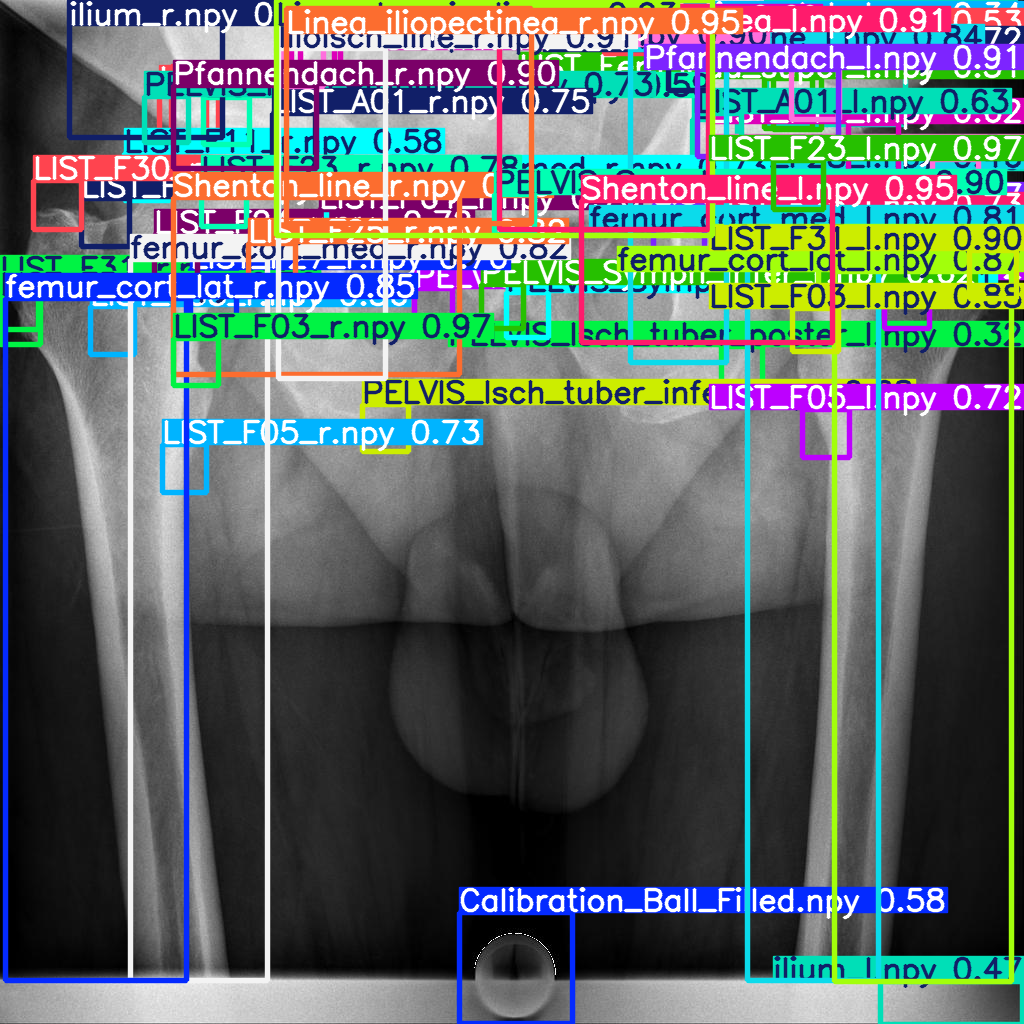

In [30]:
res_095[0].show()

In [31]:
boxes = res_095[0].boxes
boxes_dict = {}
for i, box in enumerate(boxes.xyxy):
    class_number = int((boxes.cls[i].cpu()).item())
    #class_name = convert_code2label(class_number, code_label = code_label)
    if class_number in boxes_dict.keys():
        boxes_dict[class_number].append(box.cpu().tolist())
    else: boxes_dict[class_number] = [(box.cpu()).tolist()]
boxes_dict= dict(sorted(boxes_dict.items(), key=lambda item: item[0]))

In [ ]:
import numpy as np
orig_boxes = {}
orig_boxes_xyxy = {}
with open('datasets/yolo_full/test/labels/095.txt') as f:
    for line in f.readlines():
        arr = line.split()
        orig_boxes[arr[0]] = np.array([float(x) for x in arr[1:]])*1024
        orig_boxes_xyxy[int(arr[0])] = [orig_boxes[arr[0]][0]-0.5*orig_boxes[arr[0]][2], orig_boxes[arr[0]][1]-0.5*orig_boxes[arr[0]][3], 
                                        orig_boxes[arr[0]][0]+0.5*orig_boxes[arr[0]][2], orig_boxes[arr[0]][1]+0.5*orig_boxes[arr[0]][3]]

In [33]:
def get_iou(bb1, bb2):
   
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    x_right = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_left = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_left < x_right or y_bottom < y_top:
        return 0.0

    intersection_area = (x_left - x_right) * (y_bottom - y_top)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [34]:
iou_for_one = {}
for label, box in orig_boxes_xyxy.items():
    if label in boxes_dict.keys():
        labelname = convert_code2label(label, code_label = code_label)
        iou_for_one[labelname] = get_iou(box, boxes_dict[label][0])
    else: iou_for_one[labelname] = None
iou_for_one


{'Calibration_Ball_Filled': 0.0,
 'Ilioisch_line_l': 0.019095525544058786,
 'Ilioisch_line_r': 0.4689392808511648,
 'LIST_A01_l': 0.0,
 'LIST_A01_r': 0.1858988621821905,
 'LIST_A02_l': 0.0,
 'LIST_A02_r': 0.31569561823737163,
 'LIST_F03_l': 0.0,
 'LIST_F03_r': 0.0,
 'LIST_F05_l': 0.0,
 'LIST_F05_r': 0.0,
 'LIST_F11_l': 0.0,
 'LIST_F11_r': 0.21336256049647973,
 'LIST_F23_l': 0.0,
 'LIST_F23_r': 0.10179152433872424,
 'LIST_F24_l': 0.0,
 'LIST_F24_r': 0.01954324462514696,
 'LIST_F25_l': 0.0,
 'LIST_F25_r': 0.008773437335613823,
 'LIST_F27_l': 0.0,
 'LIST_F27_r': 0.04781507500102653,
 'LIST_F28_l': None,
 'LIST_F29_l': 0.0,
 'LIST_F29_r': 0.1524573172979926,
 'LIST_F30_l': 0.0,
 'LIST_F30_r': 0.2468042459091318,
 'LIST_F31_l': 0.0,
 'LIST_F31_r': 0.0,
 'LIST_F33_l': 0.0,
 'LIST_F33_r': None,
 'LIST_FemHead_med_r': 0.05672934783800736,
 'LIST_FemHead_super_l': 0.0,
 'LIST_FemHead_super_r': 0.09332800492165379,
 'LIST_P01_l': 0.0,
 'LIST_P01_r': 0.0,
 'Linea_iliopectinea_l': 0.43840135800214

In [ ]:
from PIL import Image

tes = np.load('data/meta_testing_full_labels.npy', allow_pickle=True).item()